In [174]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import numpy as np

In [175]:
# read reservoir location dataset
res_location_fn = "../data/Reservoir-Locations.csv"
res_location = pd.read_csv(res_location_fn)

res_location.head()

,X,Y,YEAR,COUNTRY,RAT_ID,NAME,FNAME
0,100.450760,24.624938,1995.0,China,4,Manwan,5117
1,102.567564,18.539895,1972.0,Laos,5,Nam Ngum,Nam_Ngum_1
2,102.942516,18.442170,2000.0,Laos,6,Nam Leuk,5148
3,103.702018,17.259740,1973.0,Thailand,7,Nam Oun,5143
4,104.187228,17.194252,-99.0,Thailand,8,Nong Han Lake,5147


In [182]:
# meta variable, to save or not to save, that is the question
SAVE_FIG = True

# select one reservoir of choice to make initial plots
resname = "Lam Pao"
# resname = "Sirindhorn"
# resname = "Ubol Ratana"
# resname = "Nakai"
resinfo = res_location[res_location['NAME'] == resname]
resinfo

,X,Y,YEAR,COUNTRY,RAT_ID,NAME,FNAME
7,103.448123,16.622995,1969.0,Thailand,11,Lam Pao,Lam_Pao


In [183]:
# Load TMS-OS dataset
tmsos_fn = f"../data/surface-areas/tmsos/{resinfo['FNAME'].values[0]}.csv"
tmsos_df = pd.read_csv(tmsos_fn, parse_dates=['date']).set_index('date')
tmsos_df.head()

,water_area_uncorrected,non_water_area,cloud_area,unfiltered_area,cloud_percent,QUALITY_DESCRIPTION,sat,filtered_area,corrected_areas_1,corrected_trend_1,sar_trend,days_passed,area
date,,,,,,,,,,,,,
2019-01-02,137.400438,327.156545,53.883811,173.857241,10.393436,0.0,s2,173.857241,175.500307,NaN,NaN,NaN,175.500307
2019-01-07,0.000000,0.000000,458.179691,NaN,100.000000,0.0,s2,NaN,NaN,NaN,-0.301692,5.0,173.991848
2019-01-12,24.722475,70.453745,423.345712,NaN,81.644707,0.0,s2,NaN,NaN,NaN,-0.301692,5.0,172.483390
2019-01-15,141.193149,280.477505,96.848710,NaN,18.677935,0.0,l8,NaN,NaN,NaN,-0.389672,3.0,171.314375
2019-01-17,175.111689,340.312425,3.093246,175.500307,0.596556,0.0,s2,175.500307,175.500307,0.109538,-0.565632,2.0,175.500307


In [184]:
raw_areas = tmsos_df['water_area_uncorrected'].dropna()
raw_areas = raw_areas[tmsos_df['cloud_percent'] < 90]

In [185]:
# read in sar data
sar_fn = f"../data/surface-areas/sar/{resinfo['FNAME'].values[0]}_12d_sar.csv"
sar_df = pd.read_csv(sar_fn, parse_dates=['time']).rename({'time': 'date'}, axis=1).set_index('date')
sar_df.head()

,sarea
date,
2019-01-02 11:13:02,167.962138
2019-01-14 11:13:02,164.341838
2019-01-26 11:13:02,157.554252
2019-02-07 11:13:02,146.971740
2019-02-19 11:13:02,140.460648


# 1: Two subplots showing the raw vs. tmsos derived surface area

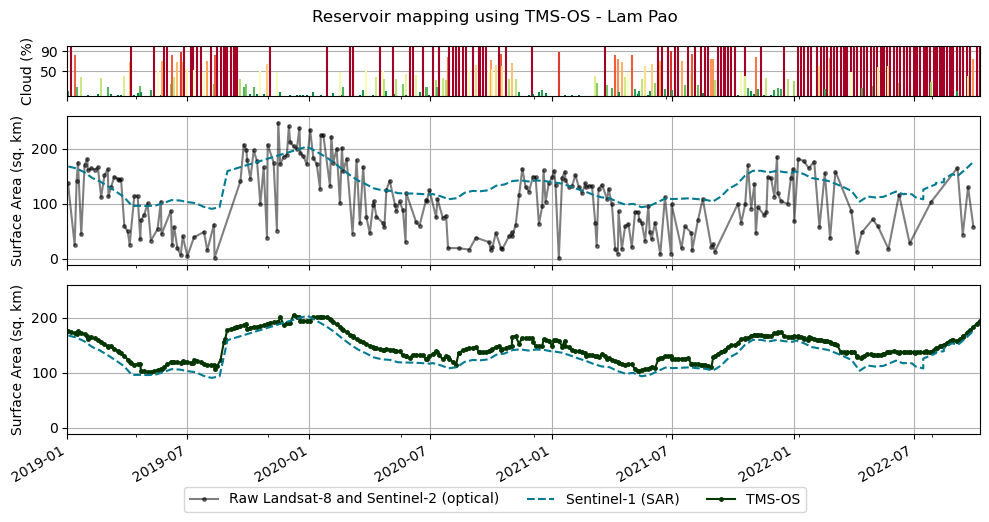

In [186]:
f, (ax0, ax1, ax2) = plt.subplots(
    figsize=(10, 5), 
    nrows = 3, 
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1, 3, 3])
)

clouds_percent = tmsos_df['cloud_percent']
# colors for vertical lines
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')
colors = [cmap(norm(v)) for v in clouds_percent]

ax0.vlines(clouds_percent.index, 0, clouds_percent.values, colors=colors)
ax0.grid(axis='y')
ax0.set_ylabel('Cloud (%)')

ax0.set_xlim(pd.to_datetime('2019-01-01'), tmsos_df.index.max())
ax0.set_ylim(0, 100)
ax0.set_yticks([50, 90])

ax1.plot(raw_areas, color='xkcd:black', label='Raw Landsat-8 and Sentinel-2 (optical)', alpha=0.5, linestyle='-', marker='.', markersize=5)
ax1.plot(sar_df['sarea'], color='xkcd:ocean', label='Sentinel-1 (SAR)', linestyle='--')

final_hdl = tmsos_df['area'].plot(color='xkcd:dark green', label='TMS-OS', marker='.', markersize=5, ax=ax2)
# sar_df['sarea'].plot(color='xkcd:ocean', label=None, linestyle='--', ax=ax2)
ax2.plot(sar_df['sarea'], color='xkcd:ocean', label=None, linestyle='--')

for ax in (ax1, ax2):
    ax.grid()
    ax.set_ylabel("Surface Area (sq. km)")

ax2.set_xlabel('')
ax2.set_ylim(ax1.get_ylim())

f.suptitle(f"Reservoir mapping using TMS-OS - {resname}")
f.legend(ncol=3, bbox_to_anchor=[0.5, 0.04], loc='upper center')
plt.tight_layout()

if SAVE_FIG:
    savedir = "../results/1/"
    if not os.path.isdir(savedir):
        try:
            os.makedirs(savedir)
        except Exception as e:
            print(f"Could't create directory: {savedir}")
            raise e
    
    f.savefig(os.path.join(savedir, f"{resname}.png"), dpi=600)

# 2: One subplot showing the raw vs. tmsos derived surface area

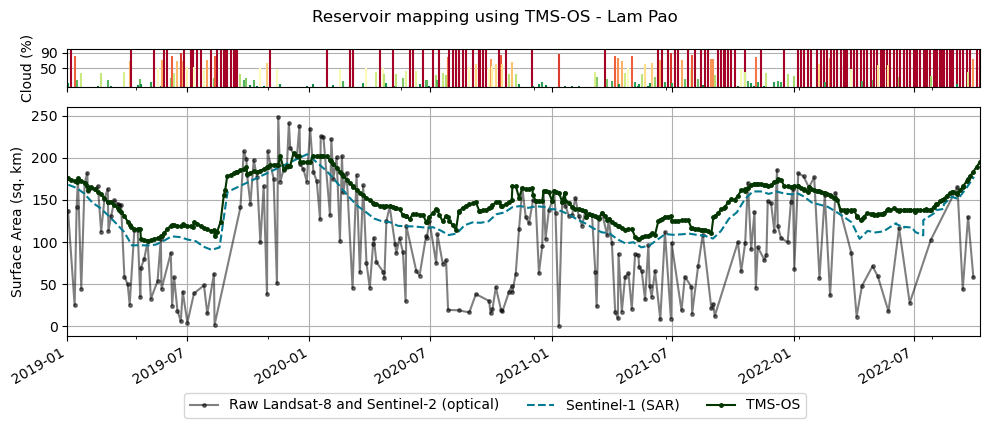

In [187]:
f, (ax0, ax1) = plt.subplots(
    figsize=(10, 4), 
    nrows = 2, 
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1, 6])
)

clouds_percent = tmsos_df['cloud_percent']
# colors for vertical lines
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')
colors = [cmap(norm(v)) for v in clouds_percent]

ax0.vlines(clouds_percent.index, 0, clouds_percent.values, colors=colors)
ax0.grid(axis='y')
ax0.set_ylabel('Cloud (%)')

ax0.set_xlim(pd.to_datetime('2019-01-01'), tmsos_df.index.max())
ax0.set_ylim(0, 100)
ax0.set_yticks([50, 90])

ax1.plot(raw_areas, color='xkcd:black', label='Raw Landsat-8 and Sentinel-2 (optical)', alpha=0.5, linestyle='-', marker='.', markersize=5)
ax1.plot(sar_df['sarea'], color='xkcd:ocean', label='Sentinel-1 (SAR)', linestyle='--')

final_hdl = tmsos_df['area'].plot(color='xkcd:dark green', label='TMS-OS', marker='.', markersize=5, ax=ax1)
# sar_df['sarea'].plot(color='xkcd:ocean', label=None, linestyle='--', ax=ax2)
# ax2.plot(sar_df['sarea'], color='xkcd:ocean', label=None, linestyle='--')

for ax in (ax1, ax2):
    ax.grid()
    ax.set_ylabel("Surface Area (sq. km)")

ax1.set_xlabel('')
ax1.set_ylim(ax1.get_ylim())

f.suptitle(f"Reservoir mapping using TMS-OS - {resname}")
f.legend(ncol=3, bbox_to_anchor=[0.5, 0.04], loc='upper center')
plt.tight_layout()

if SAVE_FIG:
    savedir = "../results/2/"
    if not os.path.isdir(savedir):
        try:
            os.makedirs(savedir)
        except Exception as e:
            print(f"Could't create directory: {savedir}")
            raise e
    
    f.savefig(os.path.join(savedir, f"{resname}.png"), dpi=600)